<a href="https://colab.research.google.com/github/windopper/NLPDeepLearningPractice/blob/main/TaggingTask/part_of_speech_Tagging_using_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 양방향 LSTM를 이용한 품사 태깅

In [3]:
import nltk
nltk.download('treebank')
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


In [4]:
tagged_sentences = nltk.corpus.treebank.tagged_sents()
print("품사 태깅이 된 문장 개수: ", len(tagged_sentences))

품사 태깅이 된 문장 개수:  3914


In [5]:
sentences, pos_tags = [], []
for tagged_sentence in tagged_sentences:
  sentence, tag_info = zip(*tagged_sentence)
  sentences.append(list(sentence))
  pos_tags.append(list(tag_info))

In [6]:
print(sentences[0])
print(pos_tags[0])

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.']


샘플의 최대 길이 :  271
샘플의 평균 길이 :  25.722023505365357


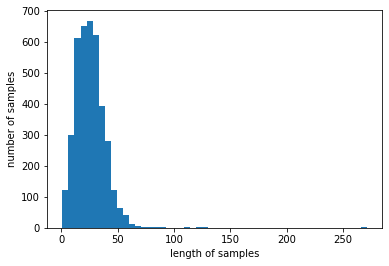

In [8]:
print('샘플의 최대 길이 : ', max(len(l) for l in sentences))
print('샘플의 평균 길이 : ', sum(map(len, sentences))/len(sentences))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [9]:
def tokenize(samples):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(samples)
  return tokenizer

In [10]:
src_tokenizer = tokenize(sentences)
tar_tokenizer = tokenize(pos_tags)

In [11]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 :', vocab_size)
print('태깅 정보 집합의 크기 : ', tag_size)

단어 집합의 크기 : 11388
태깅 정보 집합의 크기 :  47


In [12]:
x_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(pos_tags)

In [13]:
print(x_train[:2])
print(y_train[:2])

[[5601, 3746, 1, 2024, 86, 331, 1, 46, 2405, 2, 131, 27, 6, 2025, 332, 459, 2026, 3], [31, 3746, 20, 177, 4, 5602, 2915, 1, 2, 2916, 637, 147, 3]]
[[3, 3, 8, 10, 6, 7, 8, 21, 13, 4, 1, 2, 4, 7, 1, 3, 10, 9], [3, 3, 17, 1, 2, 3, 3, 8, 4, 3, 19, 1, 9]]


In [14]:
max_len = 150
x_train = pad_sequences(x_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=.2, random_state=777)

In [15]:
print('훈련 샘플 문장의 크기 : ', x_train.shape)
print('훈련 샘플 레이블의 크기 :', x_test.shape)
print('테스트 샘플 문장의 크기 : ', y_train.shape)
print("테스트 샘플 레이블의 크기 : ", y_test.shape)

훈련 샘플 문장의 크기 :  (3131, 150)
훈련 샘플 레이블의 크기 : (783, 150)
테스트 샘플 문장의 크기 :  (3131, 150)
테스트 샘플 레이블의 크기 :  (783, 150)


# 양방향 LSTM(Bi-directional LSTM)으로 POS Tagger 만들기

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam

embedding_dim = 128
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(0.001),
    metrics=['accuracy']
)

model.fit(x_train, y_train, batch_size=128, epochs=7, validation_data=(x_test, y_test))

Epoch 1/7
25/25 [==============================] - 31s 359ms/step - loss: 0.5951 - accuracy: 0.1376 - val_loss: 0.5153 - val_accuracy: 0.1666
Epoch 2/7
25/25 [==============================] - 2s 92ms/step - loss: 0.5030 - accuracy: 0.1974 - val_loss: 0.4798 - val_accuracy: 0.2494
Epoch 3/7
25/25 [==============================] - 2s 93ms/step - loss: 0.4498 - accuracy: 0.3730 - val_loss: 0.3954 - val_accuracy: 0.4608
Epoch 4/7
25/25 [==============================] - 2s 97ms/step - loss: 0.3330 - accuracy: 0.5220 - val_loss: 0.2668 - val_accuracy: 0.6038
Epoch 5/7
25/25 [==============================] - 2s 93ms/step - loss: 0.2118 - accuracy: 0.7038 - val_loss: 0.1633 - val_accuracy: 0.7841
Epoch 6/7
25/25 [==============================] - 2s 98ms/step - loss: 0.1194 - accuracy: 0.8581 - val_loss: 0.0981 - val_accuracy: 0.8777
Epoch 7/7
25/25 [==============================] - 2s 93ms/step - loss: 0.0673 - accuracy: 0.9241 - val_loss: 0.0691 - val_accuracy: 0.9059


In [18]:
print('\n 테스트 정확도 : %.4f' % (model.evaluate(x_test, y_test)[1]))

25/25 [==============================] - 1s 23ms/step - loss: 0.0691 - accuracy: 0.9059

 테스트 정확도 : 0.9059


In [20]:
index_to_word = src_tokenizer.index_word
index_to_tag = tar_tokenizer.index_word

i = 10
y_predicted = model.predict(np.array([x_test[i]]))
y_predicted = np.argmax(y_predicted, axis=-1)

print("{:15}|{:5}|{}".format('단어', '실제값', '예측값'))
print(35 * "-")

for word, tag, pred in zip(x_test[i], y_test[i], y_predicted[0]):
  if word != 0:
    print("{:17}: {:7} {}".format(index_to_word[word], index_to_tag[tag].upper(), index_to_tag[pred].upper()))

단어             |실제값  |예측값
-----------------------------------
in               : IN      IN
addition         : NN      NN
,                : ,       ,
buick            : NNP     NNP
is               : VBZ     VBZ
a                : DT      DT
relatively       : RB      RB
respected        : VBN     VBN
nameplate        : NN      NN
among            : IN      IN
american         : NNP     NNP
express          : NNP     NNP
card             : NN      NN
holders          : NNS     NNS
,                : ,       ,
says             : VBZ     VBZ
0                : -NONE-  -NONE-
*t*-1            : -NONE-  -NONE-
an               : DT      DT
american         : NNP     NNP
express          : NNP     NNP
spokeswoman      : NN      NN
.                : .       .
